In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/dedeikhsandwisaputra/rice-leafs-disease-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arjunkawle
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dedeikhsandwisaputra/rice-leafs-disease-dataset


100%|██████████| 294M/294M [00:01<00:00, 160MB/s]

In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from tqdm import tqdm
import torch.optim as optim
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torchvision import models # import pretrained models in PyTorch library
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from torchvision.datasets import ImageFolder
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac


In [ ]:
# transformations
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class RiceLeafsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
dataset = RiceLeafsDataset(
    data_dir='/content/rice-leafs-disease-dataset/RiceLeafsDisease/train'
)

In [ ]:
len(dataset)


2100

In [ ]:
data_dir = '/content/rice-leafs-disease-dataset/RiceLeafsDisease/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'bacterial_leaf_blight', 1: 'brown_spot', 2: 'healthy', 3: 'leaf_blast', 4: 'leaf_scald', 5: 'narrow_brown_spot'}


In [ ]:

train_folder = '/content/rice-leafs-disease-dataset/RiceLeafsDisease/train'
valid_folder = '/content/rice-leafs-disease-dataset/RiceLeafsDisease/validation'

train_dataset = RiceLeafsDataset(train_folder, transform=custom_transform)
val_dataset =RiceLeafsDataset(valid_folder, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True)


# train_labels = [label for _, label in train_dataset]
# test_labels = [label for _, label in val_dataset]

# print("Train labels unique:", sorted(set(train_labels)))
# print("Test labels unique:", sorted(set(test_labels)))


In [ ]:
print("Train classes:", train_dataset.data.classes)
print("Train class_to_idx:", train_dataset.data.class_to_idx)

print("Validation classes:", val_dataset.data.classes)
print("Validation class_to_idx:", val_dataset.data.class_to_idx)


Train classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']
Train class_to_idx: {'bacterial_leaf_blight': 0, 'brown_spot': 1, 'healthy': 2, 'leaf_blast': 3, 'leaf_scald': 4, 'narrow_brown_spot': 5}
Validation classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']
Validation class_to_idx: {'bacterial_leaf_blight': 0, 'brown_spot': 1, 'healthy': 2, 'leaf_blast': 3, 'leaf_scald': 4, 'narrow_brown_spot': 5}


In [ ]:
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 77.4MB/s]


In [ ]:
for param in vgg16.features.parameters():
  param.requires_grad=False

In [ ]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 6)
)

In [ ]:
vgg16 = vgg16.to(device)

In [ ]:

# class SimpleLeafClassifier(nn.Module):
#     def __init__(self, num_classes=6):
#         super(SimpleLeafClassifier, self).__init__()
#         # Load pretrained ResNet18
#         self.base_model = models.resnet18(pretrained=True)

#         # Get the number of input features for the final fc layer
#         in_features = self.base_model.fc.in_features

#         # Replace the final fc layer with a new one for 6 classes
#         self.base_model.fc = nn.Linear(in_features, num_classes)

#     def forward(self, x):
#         return self.base_model(x)


In [ ]:
# model = SimpleLeafClassifier(num_classes=6)
# print(str(model)[:500])

In [ ]:
# example_out = model(images)
# example_out.shape # [batch_size, num_classes]

In [ ]:
learning_rate = 0.0001
epochs = 10


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=learning_rate)

In [ ]:
print("Torch CUDA available:", torch.cuda.is_available())
print("Device in use:", torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

Torch CUDA available: True
Device in use: cuda:0
GPU Name: Tesla T4


In [ ]:
# # Simple training loop
# num_epochs = 10
# train_losses, train_accuracies = [], []

# device = torch.device("cuda:0")

# model = SimpleLeafClassifier(num_classes=53)
# model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0

#     for images, labels in tqdm(train_loader, desc='Training loop'):
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * labels.size(0)

#         # Accuracy calculation
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

#     train_loss = running_loss / len(train_loader.dataset)
#     train_acc = correct / total * 100

#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)

#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")


In [ ]:
from tqdm import tqdm  # import tqdm

for epoch in range(epochs):
    total_epoch_loss = 0

    # wrap train_loader with tqdm
    for batch_features, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        # forward pass
        outputs = vgg16(batch_features)

        # calculate loss
        loss = criterion(outputs, batch_labels)

        # back pass
        optimizer.zero_grad()
        loss.backward()

        # update grads
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch 1/10: 100%|██████████| 66/66 [00:59<00:00,  1.10it/s]


Epoch: 1 , Loss: 0.1710664817329609


Epoch 2/10: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch: 2 , Loss: 0.0488788658880036


Epoch 3/10: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch: 3 , Loss: 0.01736398643080258


Epoch 4/10: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch: 4 , Loss: 0.015166343747158393


Epoch 5/10: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch: 5 , Loss: 0.003366710619902182


Epoch 6/10: 100%|██████████| 66/66 [01:00<00:00,  1.08it/s]


Epoch: 6 , Loss: 0.0019369697618072457


Epoch 7/10: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch: 7 , Loss: 0.0013983001779045233


Epoch 8/10: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch: 8 , Loss: 0.001085037178585701


Epoch 9/10: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]


Epoch: 9 , Loss: 0.000869674107172724


Epoch 10/10: 100%|██████████| 66/66 [01:01<00:00,  1.08it/s]

Epoch: 10 , Loss: 0.0007237619041310003


In [ ]:
import torch
print("Torch CUDA available:", torch.cuda.is_available())
print("Device in use:", torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


Torch CUDA available: True
Device in use: cuda:0
GPU Name: Tesla T4


In [ ]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# evaluation on test data
vgg16.eval()
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in val_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)
print(f"Accuracy: {100 * correct/total:.2f}%")


0.9602272727272727
Accuracy: 96.02%


Test Loss: 0.2305, Test Accuracy: 96.02%


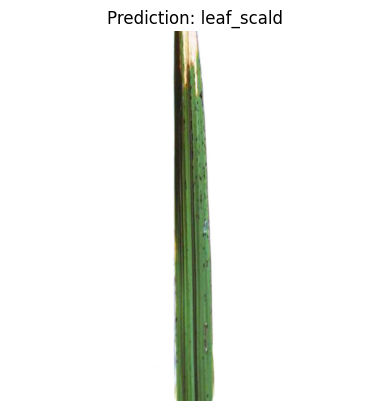

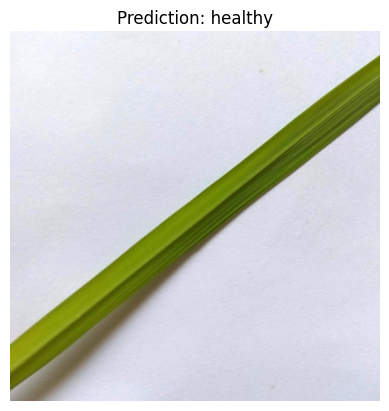

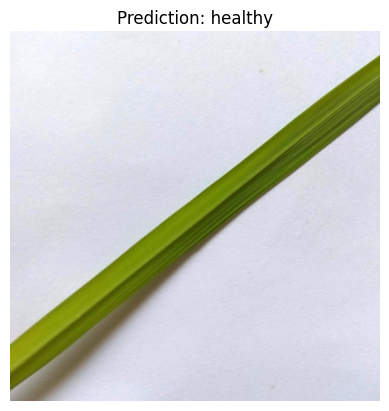

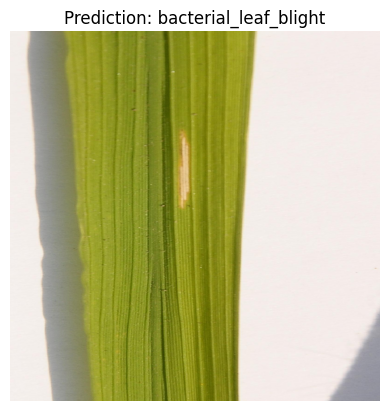

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F

# Make sure model is in eval mode
vgg16.eval()

correct = 0
total = 0
test_loss = 0.0

# Example images you want to visualize
example_image_paths = [
    "/content/rice-leafs-disease-dataset/RiceLeafsDisease/validation/leaf_scald/leaf_scald_val (10).jpg",
    "/content/rice-leafs-disease-dataset/RiceLeafsDisease/validation/healthy/healthy_val (10).jpg",
    "/content/rice-leafs-disease-dataset/RiceLeafsDisease/validation/healthy/healthy_val (10).jpg",
    "/content/rice-leafs-disease-dataset/RiceLeafsDisease/validation/bacterial_leaf_blight/bacterial_val (10).jpg"
]

# Define the same transform used for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Function to visualize image and prediction
def show_prediction(image_path, predicted_class, class_names):
    img = Image.open(image_path).convert("RGB")
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[predicted_class]}")
    plt.axis("off")
    plt.show()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Compute average loss and accuracy
avg_test_loss = test_loss / len(val_loader.dataset)
test_acc = correct / total * 100
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Visualize example images
for img_path in example_image_paths:
    img = Image.open(img_path).convert("RGB")
    img_tensor = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = vgg16(img_tensor)
        prob = F.softmax(output, dim=1)
        pred_class = torch.argmax(prob, 1).item()

    show_prediction(img_path, pred_class, val_dataset.classes)


In [ ]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

def evaluate_and_visualize(model, dataset_path, device, n_samples=10, batch_size=32):
    """
    Evaluate accuracy on validation set and visualize random samples without altering the images.
    Displays file names instead of full paths.
    """
    # Model input transform
    input_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Dataset for model input
    val_dataset = RiceLeafsDataset(dataset_path, transform=input_transform)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # --- Compute overall accuracy ---
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total * 100
    print(f"Validation Accuracy: {acc:.2f}%")

    # --- Visualize random samples ---
    # List all images and labels from the folder structure
    all_image_paths = []
    all_labels = []
    for class_idx, class_name in enumerate(val_dataset.classes):
        class_folder = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_folder):
            if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                all_image_paths.append(os.path.join(class_folder, img_name))
                all_labels.append(class_idx)

    # Pick random samples
    indices = random.sample(range(len(all_image_paths)), min(n_samples, len(all_image_paths)))
    for idx in indices:
        img_path = all_image_paths[idx]
        label = all_labels[idx]

        # Load original image for plotting
        img = Image.open(img_path).convert("RGB")

        # Transform for model input
        img_tensor = input_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)
            prob = F.softmax(output, dim=1)
            pred_class = torch.argmax(prob, 1).item()

        # Plot original image with file name
        file_name = os.path.basename(img_path)
        plt.imshow(img)
        plt.title(f"{file_name}\nPredicted: {val_dataset.classes[pred_class]}, Actual: {val_dataset.classes[label]}")
        plt.axis("off")
        plt.show()


Validation Accuracy: 95.08%


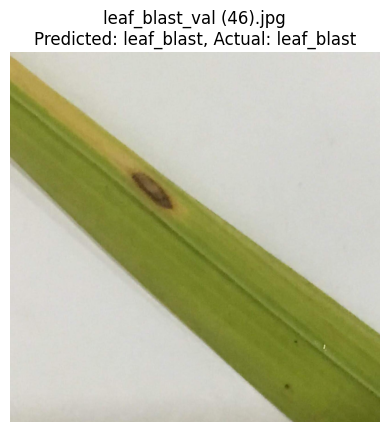

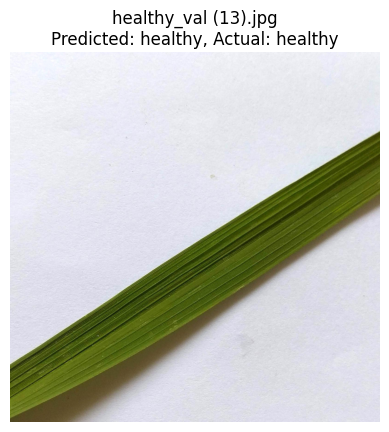

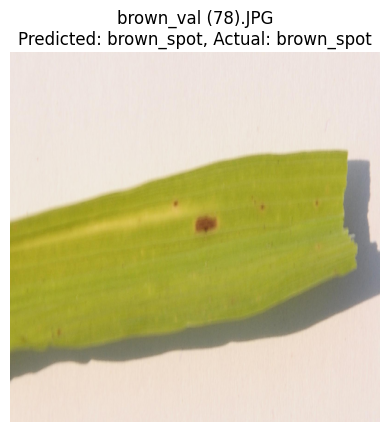

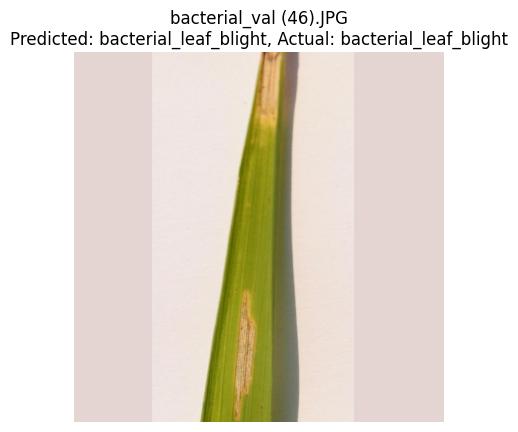

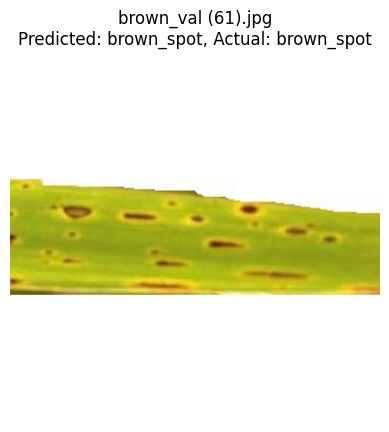

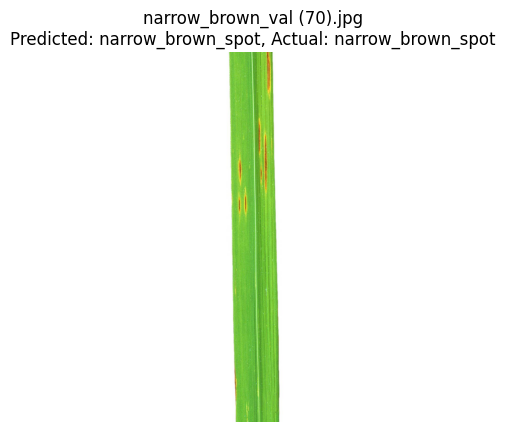

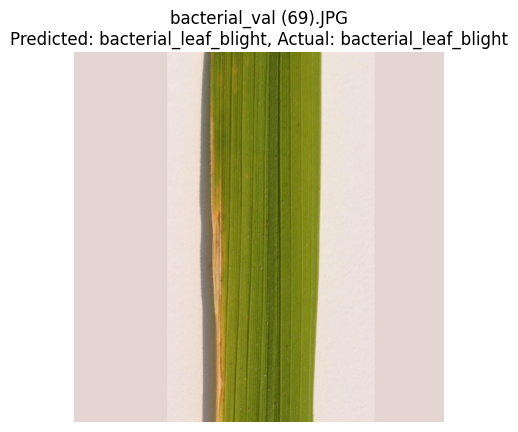

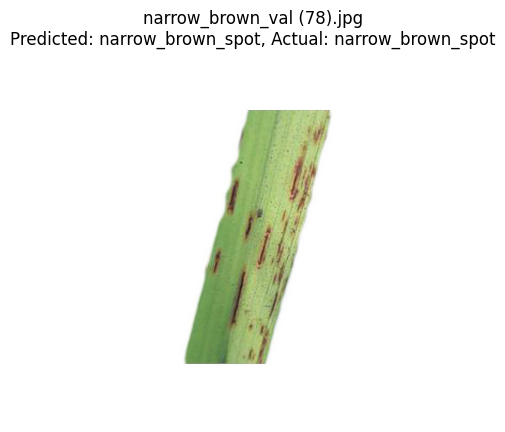

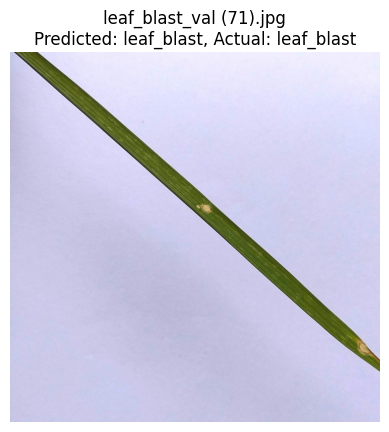

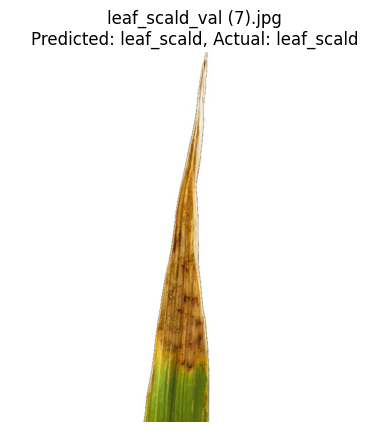

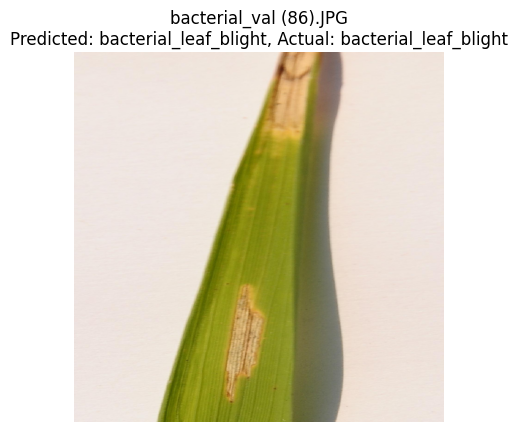

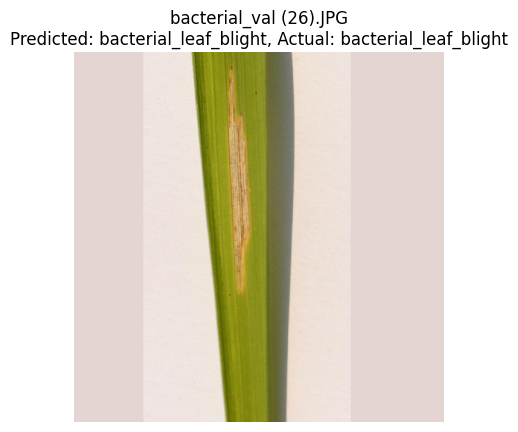

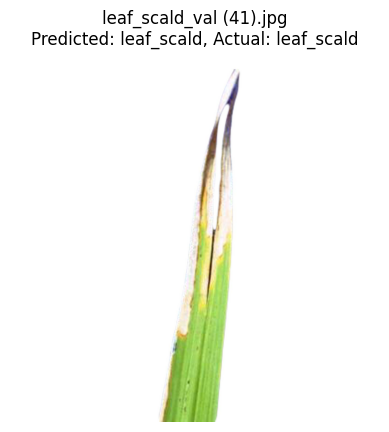

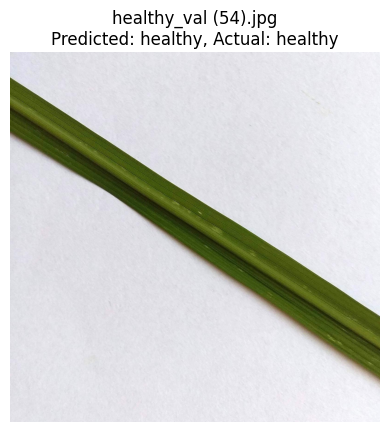

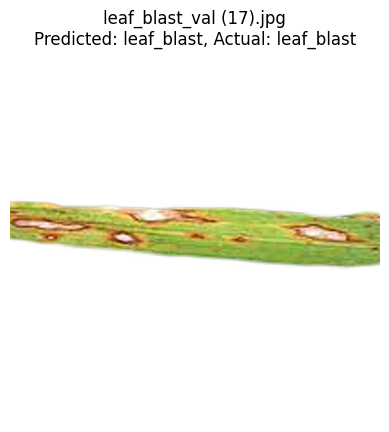

In [ ]:
validation_folder = "/content/rice-leafs-disease-dataset/RiceLeafsDisease/validation"
evaluate_and_visualize(vgg16, validation_folder, device, n_samples=15)


In [ ]:
# Save the full model
torch.save(vgg16, "vgg16_riceleafs_full.pth")


In [ ]:
import torch
import os

# Save model (state_dict or full model)
torch.save(vgg16.state_dict(), "vgg16_riceleafs.pth")

# Check file size in MB
file_size = os.path.getsize("vgg16_riceleafs.pth") / (1024 * 1024)
print(f"Model file size: {file_size:.2f} MB")


Model file size: 156.16 MB


In [ ]:
from google.colab import files

# If you saved the model as "vgg16_riceleafs_full.pth"
files.download("vgg16_riceleafs_full.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>